In [9]:
# install ipywidgets
# jupyter nbextension enable --py widgetsnbextension
# pip install ipywidgets

SyntaxError: invalid syntax (2061305638.py, line 2)

In [2]:
import pandas as pd
import ipywidgets as widgets
from skimage import io
from skimage.io import imread, imshow

import asyncio
import numpy as np
import seaborn as sns
from sklearn import preprocessing
import pickle
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import os
from functools import reduce
from sklearn.cluster import KMeans
from skimage import exposure
from skimage.transform import resize


import pickle
import matplotlib.pyplot as plt
import os
import time

import pandas as pd
from sqlalchemy import create_engine
from functools import reduce

from utils.read_data import *
from utils.visualize_data import *
from utils.correlations import *


import random


In [147]:
#@title Take a look at the images in a shuffled order, without the labels. 
#@markdown * Do you see any tendencies? Look at the nuclei size, intensity of the stains.

df = pd.read_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv', low_memory=False)
grouped=df.groupby(['Track_ID'])

#This spreadsheet must be quality controlled: remove tracks with less than 5 cells
dflist=[]
# print(grouped)
for i, newdf in grouped:
    if newdf.shape[0]>5:
        dflist.append(newdf)
df=pd.concat(dflist)
print(df.shape)

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_71365/1128674409.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


(1643, 458)


In [148]:
#@title Please run to activate dropdown function
def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value

In [149]:
#CHECKING DOUBLE POSITIVE STATUS MANUALLY 

#For the first cell run

# df= pd.read_csv("/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv", header = 0)
df['Final_Cell_ID']=df['Track_ID']
df['Timeframe_Time_no_date']='x'

for i in df.index: 
    df.loc[i,'Timeframe_Time_no_date']=str(df.loc[i,'Timeframe_Time'])[-8:]
print(df['Timeframe_Time_no_date'])

#for all the cells after that run 
#df= pd.read_csv('/Users/secchim/Documents/manuallychecked.csv', header = 0)

df_list = [option for option in list(df['Metadata_VWF'].unique())]
# df_list = [option for option in df.filter(regex=r'Metadata', axis=1).columns]
dropdown(df_list)

6       13:09:46
7       13:12:46
8       13:15:46
9       13:18:46
10      13:21:46
          ...   
2351    09:29:37
2352    09:32:37
2353    09:35:37
2354    09:38:37
2355    09:41:37
Name: Timeframe_Time_no_date, Length: 1643, dtype: object


Dropdown(description='Choose', options=('VWF_043_MS211125_m3-homeostasis_movie2_P4', 'VWF_043_MS211125_m3-home…

15
7
290.90501792114696 348.5967741935484 VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P32+_1.5259021893143654e-05


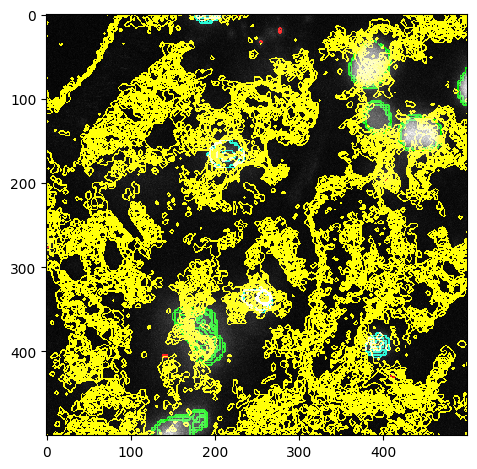

In [178]:
VWF_meta = dropdown_output
# print(VWF_meta)

grouped=df[df['Metadata_VWF']==VWF_meta]
# print(grouped.shape[0])
print(len(grouped.index))
timeframe_length= len(grouped.index)

random_timeframe = random.randint(1, timeframe_length)
print(random_timeframe)

sample = '/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/'+VWF_meta+'/'+VWF_meta+'_Ch1_xyzCorrected.tif - T='+str(random_timeframe)+'GFP.tiff'
#sample = '/Users/secchim/Downloads/CellProfiler/movie_processing/1_tif'+VWF_meta+'Ch1_xyzCorrected.tif - T='+random_timeframe+'.tif'

sample_data = io.imread(sample)
# print(sample_data)
sample_data.shape
sample_max=sample_data[0,:,:]
# print(sample_max)
# sample_max.shape
for i in range(0, sample_data.shape[0]):
    # print(i)
    #this line calculates the maximum intensity projection?
    sample_max= np.maximum(sample_max, sample_data[i,:,:])
# sample_max

#PRINT LOCATION OF THE CELL WHICH IS IMPORTANT IF THERE ARE MUTLIPLE CELLS IN THE SAME FRAME
for i in list(grouped['Track_ID'].unique()):
    ti=grouped[grouped['Track_ID']==i]
    indexti=ti.index[0]
    # print(ti)
    print(ti.loc[indexti,'Location_Center_X'], ti.loc[indexti,'Location_Center_Y'], ti.loc[indexti,'Track_ID'])

# subdata=df[df['FileName_GFP']==(VWF_meta+'_Ch1_xyzCorrected.tif - T='+str(random_timeframe)+'GFP.tif')]
# print((subdata.loc[1,'Location_Center_X']),(subdata.loc[1,'Location_Center_Y']))
imshow(sample_max/sample_data.max())


In [174]:
df_tracks = [option for option in (list(grouped['Track_ID'].unique()))]
# df_list = [option for option in df.filter(regex=r'Metadata', axis=1).columns]
dropdown(df_tracks)

Dropdown(description='Choose', options=('VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_3.051804378628731e-0…

In [175]:
trackdropdown=dropdown_output
df_Hoxb5status = [option for option in ('yes', 'no','unclear')]
dropdown(df_Hoxb5status)

Dropdown(description='Choose', options=('yes', 'no', 'unclear'), value='yes')

In [177]:

manual_Hoxb5status = dropdown_output
for i in df.index:
    if df.loc[i,'Track_ID'] == trackdropdown:
        
        if manual_Hoxb5status == 'yes':
            df.loc[i,'Metadata_Hoxb5status'] = 'DP'
        elif manual_Hoxb5status == 'no':
            df[i,'Metadata_Hoxb5status'] = 'SP'
        else:
            print('unclear- rerun')
#df.to_csv('/Users/secchim/Documents/manuallychecked.csv')

# if manual_Hoxb5status == 'unclear':
#     random_timeframe = random.randint(1, timeframe_length)

#     sample = '/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/'+VWF_meta+'/'+VWF_meta+'_Ch1_xyzCorrected.tif - T='+str(random_timeframe)+'GFP.tiff'
#     #sample = '/Users/secchim/Downloads/CellProfiler/movie_processing/1_tif'+VWF_meta+'Ch1_xyzCorrected.tif - T='+random_timeframe+'.tif'

#     sample_data = io.imread(sample)
#     # print(sample_data)
#     sample_data.shape
#     sample_max=sample_data[0,:,:]
#     print(sample_max)
#     # sample_max.shape
#     for i in range(0, sample_data.shape[0]):
#         # print(i)
#         sample_max= np.maximum(sample_max, sample_data[i,:,:])
#     # sample_max

#     imshow(sample_max/sample_data.max())



unclear- rerun
unclear- rerun
unclear- rerun
unclear- rerun
unclear- rerun
unclear- rerun
unclear- rerun
unclear- rerun
unclear- rerun
unclear- rerun
unclear- rerun
unclear- rerun
unclear- rerun
unclear- rerun
unclear- rerun
unclear- rerun


In [111]:
grouped=df.groupby(['Cell_group'])

dflist=[]
# print(grouped)
for i, newdf in grouped:
    if len(list(newdf['Metadata_VWF'].unique()))>2 and len(list(newdf['AcquisitionTime'].unique()))>2:
        # print(i)
        dflist.append(i)
# list_movie=pd.concat(dflist)
# print(dflist)


df_list = [option for option in dflist]
# df_list = [option for option in df.filter(regex=r'Metadata', axis=1).columns]
dropdown(df_list)

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_71365/3280431715.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


Dropdown(description='Choose', options=('VWF_043_MS211126_M4_P7++', 'VWF_048_MS220118_M3_P6DP+', 'VWF_053_MS22…

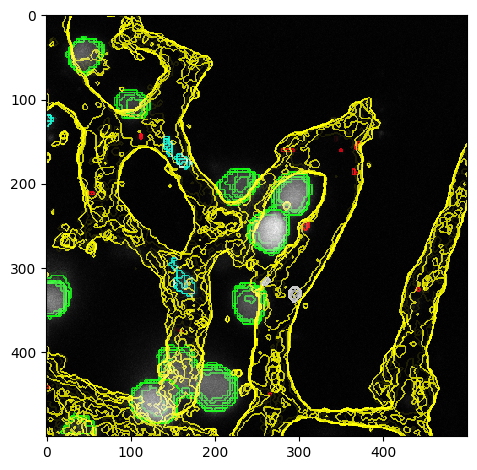

In [138]:
#remove when done testing

VWF_Cell = dropdown_output

# imshow(sample_max)
#this line crops the image to the cell and its surroundings 200 pixels square
imshow(sample_max[0:200, 0:200]) #https://www.geeksforgeeks.org/how-to-crop-an-image-using-the-numpy-module/
# imshow(sample_max/sample_data.max())
# imshow(sample_max)
#Location_Center_X

more than 2 movies
AcquisitionTime
14:42:57    101
16:17:57    154
17:14:28    213
Name: Metadata_Timepoint, dtype: int64 AcquisitionTime
14:42:57    122
16:17:57    164
17:14:28    227
Name: Metadata_Timepoint, dtype: int64
/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/VWF_043_MS211126_m4-pltdepletionmovie2_P7++/VWF_043_MS211126_m4-pltdepletionmovie2_P7++_Ch1_xyzCorrected.tif - T=0GFP.tiff
268.6388888888889 342.4583333333333
/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/VWF_043_MS211126_m4-homeostasismovie_2_P7++/VWF_043_MS211126_m4-homeostasismovie_2_P7++_Ch1_xyzCorrected.tif - T=21GFP.tiff
251.0451055662188 212.0204359673025
/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/VWF_043_MS211126_m4-pltdepletionmovie3_P7++/VWF_043_MS211126_m4-pltdepletionmovie3_P7++_Ch1_xyzCorrected.tif - T=0GFP.tiff
298.1666666666667 404.7
/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/VWF_043_MS211126_m4-pltdepletionmovie

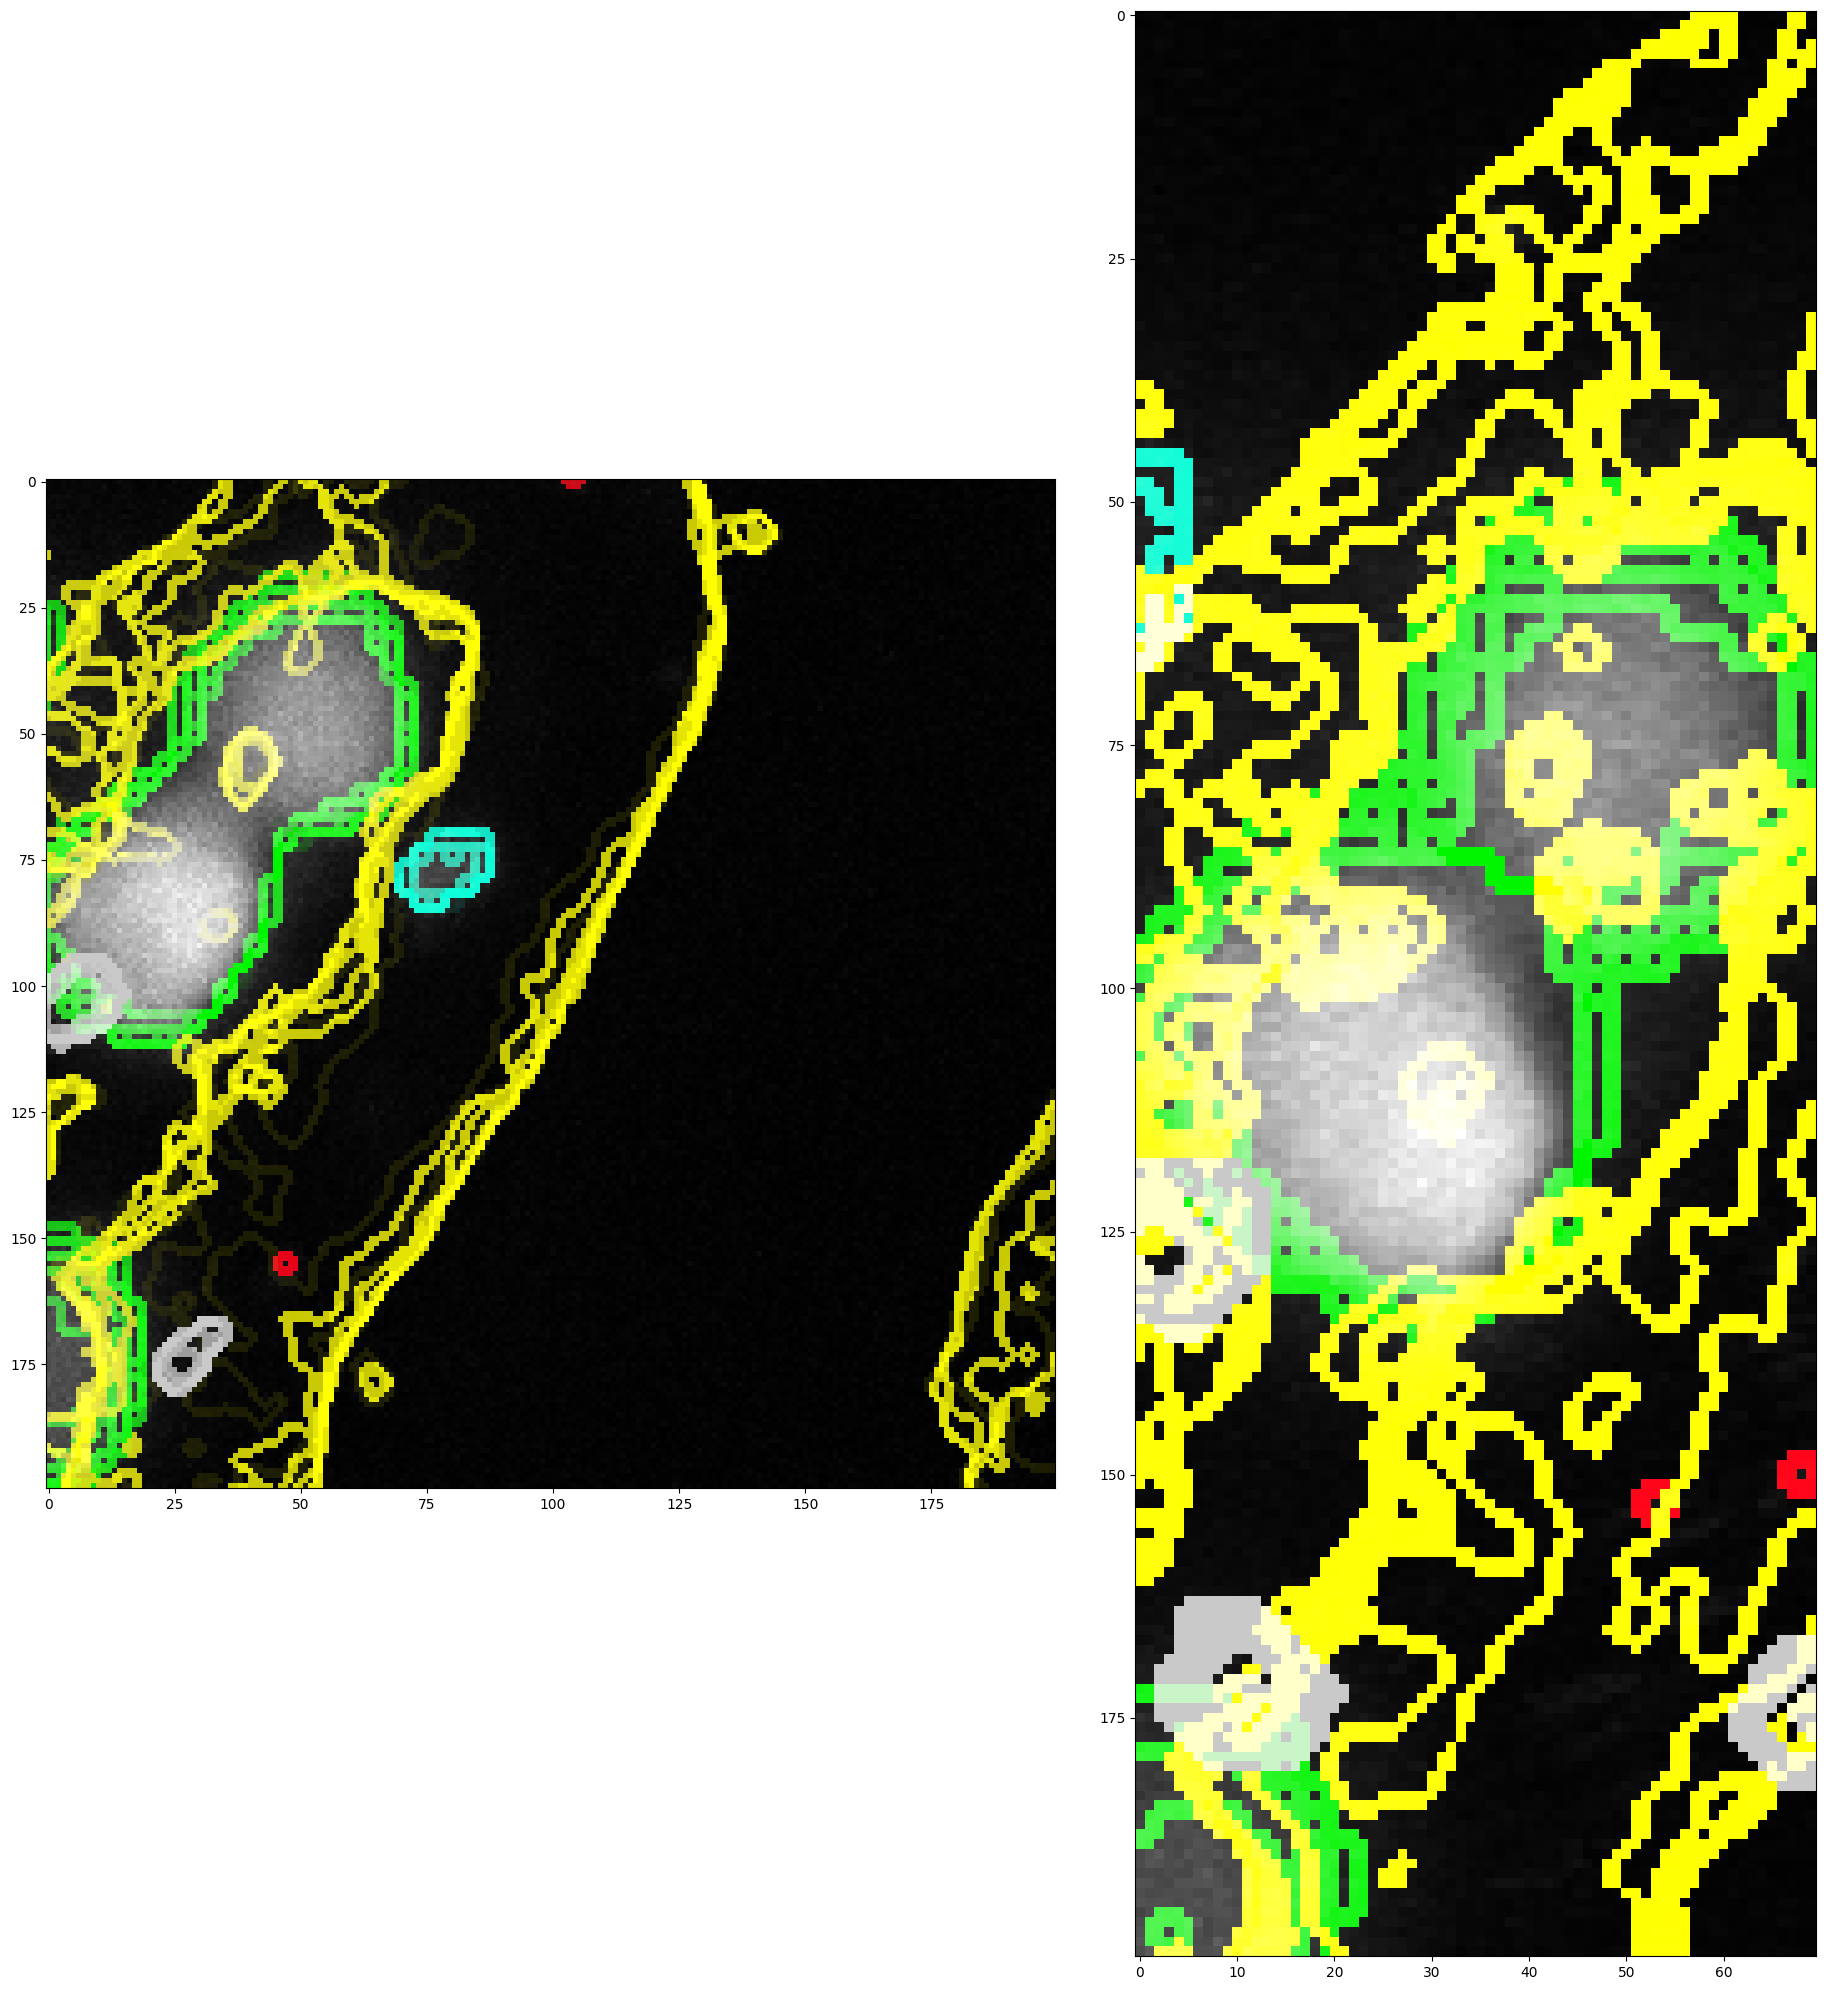

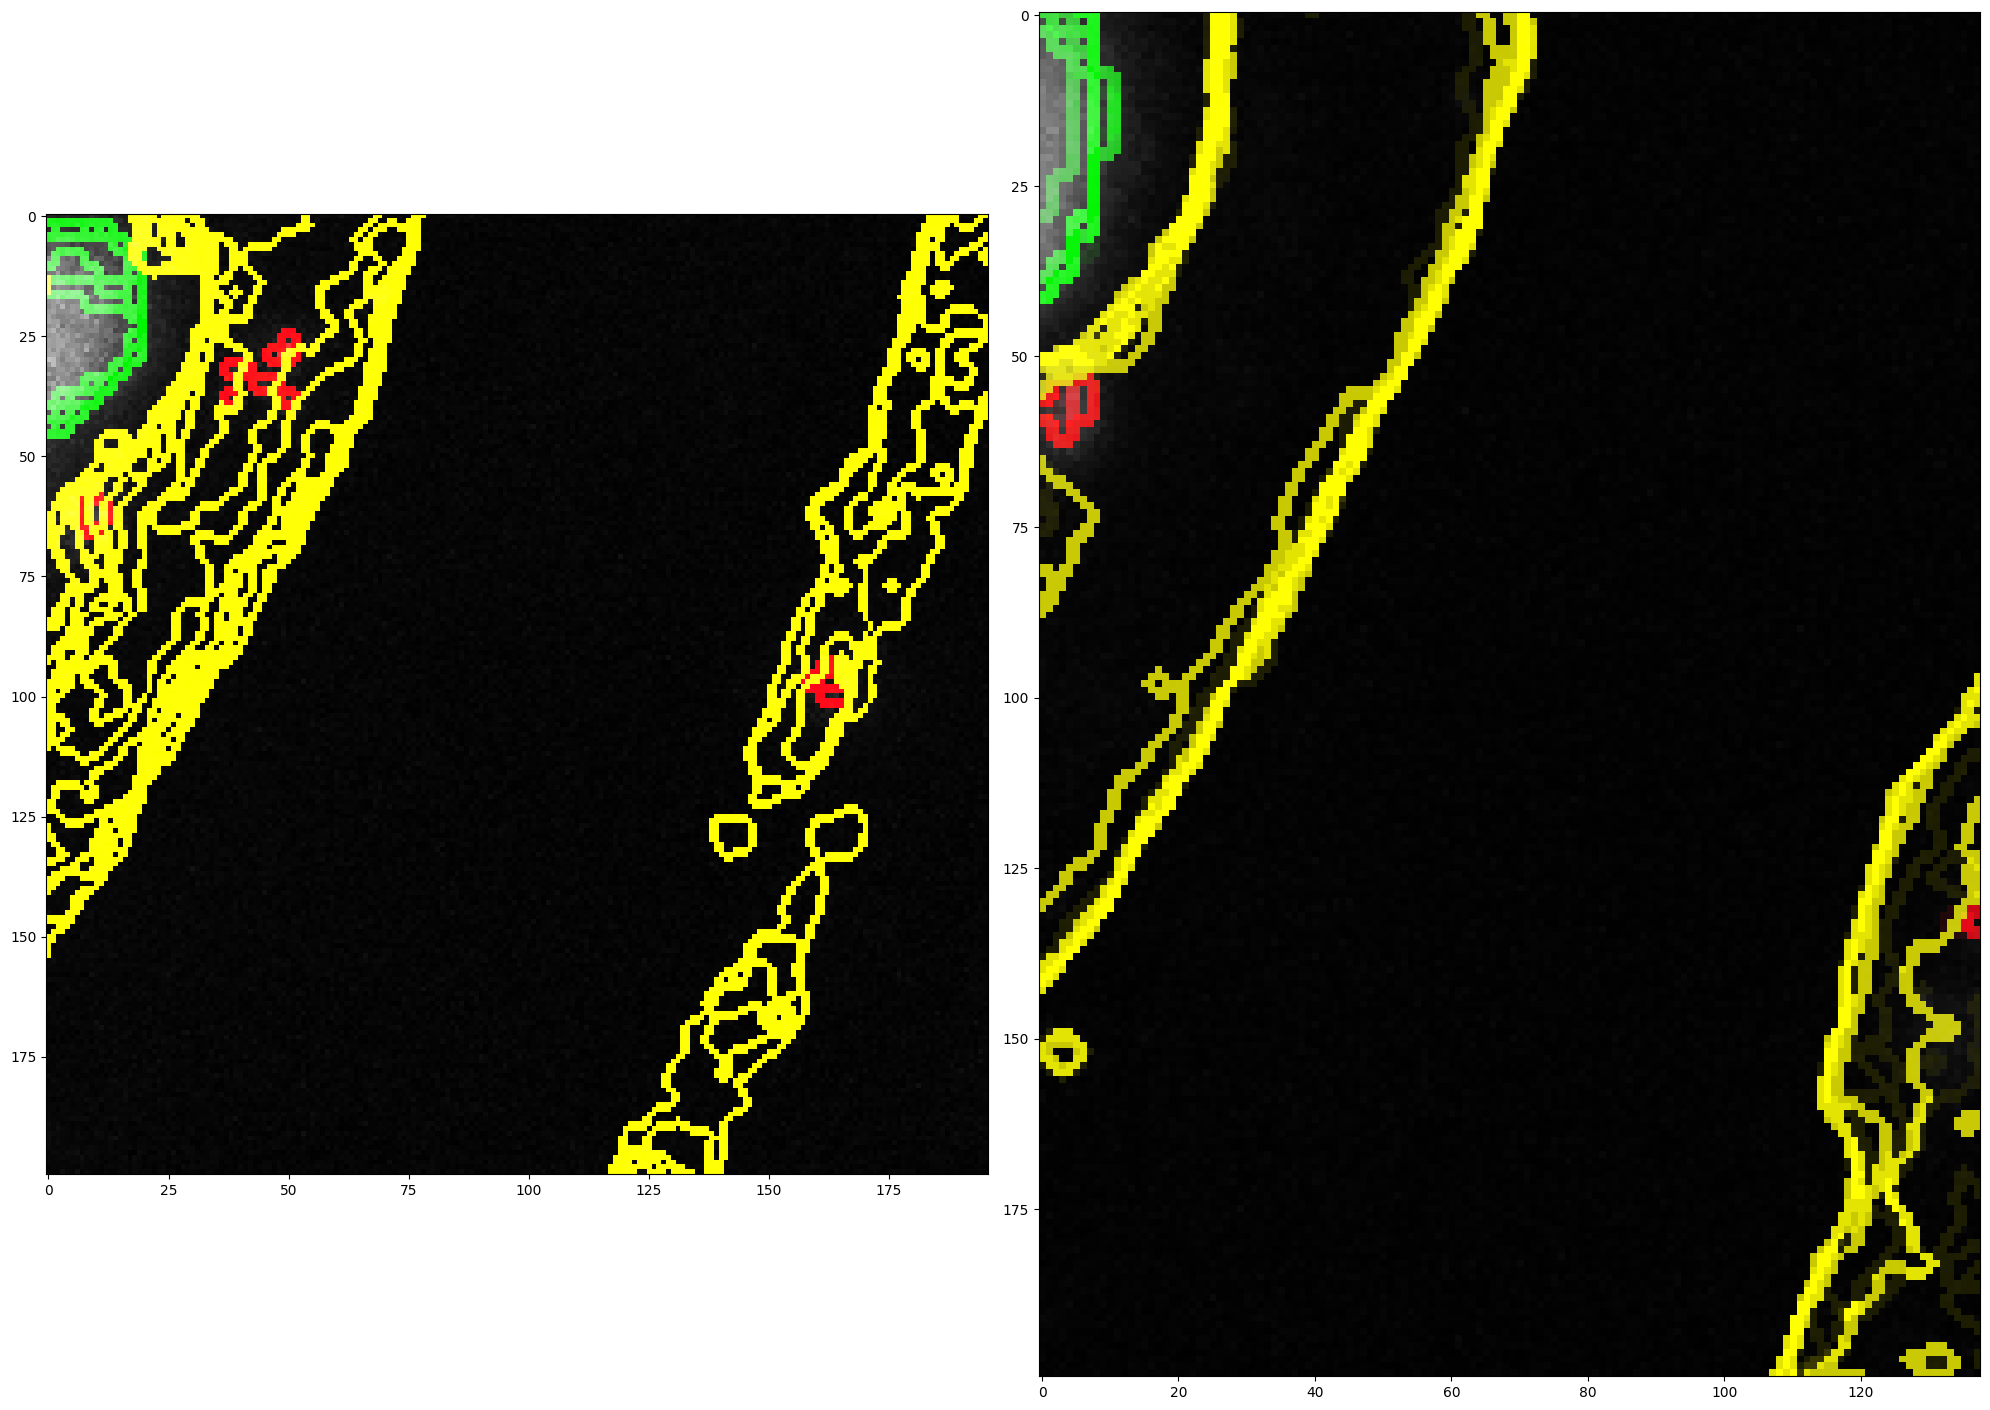

In [146]:
#CHECKING TRACK LINKAGE 

VWF_Cell = dropdown_output
#df= pd.read_csv('/Users/secchim/Documents/manuallychecked.csv', header = 0)
# VWF_Cell=grouped['Cell_group'].unique()
# print(VWF_Cell)


grouped2=df[df['Cell_group']==VWF_Cell]
# print(grouped.shape[0])
# print(len(grouped.index))
timeframe_length= len(grouped2.index)
# print(grouped2)

# sample = '/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/'+VWF_meta+'/'+VWF_meta+'_Ch1_xyzCorrected.tif - T='+str(timeframe_length)+'GFP.tiff'
#sample = '/Users/secchim/Downloads/CellProfiler/movie_processing/1_tif'+VWF_meta+'Ch1_xyzCorrected.tif - T='+random_timeframe+'.tif'


#CONNECT TRACKS 
#BE CAREFUL NOT TO CONNECT TRACKS THAT ARE IN THE SAME MOVIE
#shouldn't happen because looking at last and first 
#having a condition: time acquisition being different => went for that one
#or having a condition: metadata_vwf being different

if len(list(grouped2['Metadata_VWF'].unique()))>2:
    print('more than 2 movies')
    #The last timepoint of the first movie and the first timepoint of the second 
    #The tracked cell coordinates 

    #indexes of the rows of the earliest and latest timepoint of all the movies with the same position
    #PB THE CELL IS NOT NECESSARILY FOUND IN THESE FRAMES? BUT IT SHOULD BE because it should only include timeframes with cells
    min, max = grouped2.groupby('AcquisitionTime')['Metadata_Timepoint'].idxmin(), grouped2.groupby('AcquisitionTime')['Metadata_Timepoint'].idxmax()
    print(min,max)

#the images will be in different folders
    for i in range (1, len(min)):
        img_1=str(grouped2.loc[min[i],'FileName_GFP'])[:-4]+'GFP.tiff'
        path1='/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/'+ str(grouped2.loc[min[i],'Metadata_VWF'])+'/'+img_1
        print(path1)
        #location of the cell in that row
        crop1x=grouped2.loc[min[i],'Location_Center_X']
        crop1y=grouped2.loc[min[i],'Location_Center_Y']
        print(crop1x, crop1y)
        img_2=str(grouped2.loc[max[i-1],'FileName_GFP'])[:-4]+'GFP.tiff'
        path2='/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/'+ str(grouped2.loc[max[i-1],'Metadata_VWF'])+'/'+img_2
        print(path2)
        crop2x=grouped2.loc[max[i-1],'Location_Center_X']
        crop2y=grouped2.loc[min[i-1],'Location_Center_Y']
        print(crop2x, crop2y)
    
        sample_data = io.imread(path1)
        sample_data.shape
        sample_max=sample_data[0,:,:]
        #calculates the maximum intensity projection
        for i in range(0, sample_data.shape[0]):
            # print(i)
            sample_max= np.maximum(sample_max, sample_data[i,:,:])
        # sample_max
        
        fig = plt.figure(figsize=(20, 20))
        rows=1
        columns=2
        fig.add_subplot(rows, columns, 1)
        # imshow(sample_max/sample_data.max())
        #crops the image to the cell and its surroundings 100 pixels 
        #pb if the cell is at the edge of the image
        if crop1x-100<0:
            X1min=0
        else:
            X1min=crop1x-100
        if crop1x+100>sample_max.shape[0]:
            X1max=sample_max.shape[0]
        else:
            X1max=crop1x+100
        if crop1y-100<0:
            Y1min=0
        else:
            Y1min=crop1y-100
        if crop1y+100>sample_max.shape[1]:
            Y1max=sample_max.shape[1]
        else:
            Y1max=crop1y+100
        if crop2x-100<0:
            X2min=0
        else:
            X2min=crop2x-100
        if crop2x+100>sample_max.shape[0]:
            X2max=sample_max.shape[0]
        else:
            X2max=crop2x+100
        if crop1y-100<0:
            Y2min=0
        else:
            Y2min=crop1y-100
        if crop2y+100>sample_max.shape[1]:
            Y2max=sample_max.shape[1]
        else:
            Y2max=crop2y+100
        imshow(sample_max[int(X1min):int(X1max), int(Y1min):int(Y1max)])
        
        sample_data = io.imread(path2)
        # print(sample_data)
        sample_data.shape
        sample_max=sample_data[0,:,:]
        # print(sample_max)
        # sample_max.shape
        for i in range(0, sample_data.shape[0]):
            # print(i)
            sample_max= np.maximum(sample_max, sample_data[i,:,:])
        fig.add_subplot(rows, columns, 2)
        # imshow(sample_max/sample_data.max())
        imshow(sample_max[int(X2min):int(X2max), int(Y2min):int(Y2max)])

# for i in list(grouped2['Track_ID'].unique()):
#     ti=grouped2[grouped2['Track_ID']==i]
#     indexti=ti.index[0]
#     # print(ti)
#     print(ti.loc[indexti,'Location_Center_X'], ti.loc[indexti,'Location_Center_Y'], ti.loc[indexti,'Track_ID'])


VWF_043_MS211126_M4_P7++
VWF_048_MS220118_M3_P6DP+
VWF_053_MS220209_M1_P14partlygreen
VWF_053_MS220209_M1_P16DP
VWF_053_MS220209_M1_P18kuo
VWF_053_MS220209_M1_P24kuomk
VWF_053_MS220209_M1_P26kuovascu
VWF_063_MS220428_M1_P15


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_71365/1648484033.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


In [4]:
#@title Choose a label column where your **negative control** is. Please choose **"Metadata_compound** for this demo
df_list = [option for option in df.filter(regex=r'Metadata', axis=1).columns]
dropdown(df_list)

Dropdown(description='Choose', options=('Metadata_Channelnb', 'Metadata_FileLocation', 'Metadata_Format1', 'Me…

In [4]:
#@title Choose the method to choose cells to plot:
def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value

choose_cells = ['random', 'representative']
dropdown(choose_cells)

Dropdown(description='Choose', options=('random', 'representative'), value='random')

In [5]:
#@title Run to save selected methods 
plot = dropdown_output
print(plot)

representative


In [6]:
# #@title Use correlations to order the image plot? Choose Yes or No
# def dropdown(input_list):
#   import ipywidgets as widgets
#   global dropdown_output
#   drop_down = widgets.Dropdown(options=input_list,
#                                   description='Choose',
#                                   disabled=False)

#   def dropdown_handler(change):
#       global dropdown_output
#       dropdown_output = change.new  # This line isn't working
#   drop_down.observe(dropdown_handler, names='value')
#   display(drop_down)
#   dropdown_output = drop_down.value

# choose_cells = ['yes', 'no']
# dropdown(choose_cells)

Dropdown(description='Choose', options=('yes', 'no'), value='yes')

In [7]:
# #@title Run to save selected methods 
# corr_input = dropdown_output
# corr_input_transform = stringToBool(corr_input)
# print(corr_input)

NameError: name 'stringToBool' is not defined

In [11]:
#@title Choose number of cells to plot for each group
import panel as pn
pn.extension()

int_slider = pn.widgets.IntSlider(name='How many cells would you like to plot for each subgroup?', start=1, end=10, step=1, value=1)

int_slider

BokehModel(combine_events=True, render_bundle={'docs_json': {'29ca240f-e67c-4366-93d4-871c3f1c1aa7': {'defs': …

In [12]:
#@title Run to save previous selection
val_ncells = int_slider.value
print(val_ncells)

1


In [ ]:
#@title Select cells and add it to a new DataFrame

if plot == 'random':
    df_selected_smp = random_select(df, list_to_plot = list_to_plot, sort_by = sort_by, box_size = box_size, correlation = corr_input_transform, n_cells = val_ncells)
elif plot == 'representative':
    df_selected_smp = representative_kmeans_select(df, list_to_plot = list_to_plot, sort_by = sort_by, box_size = box_size, correlation = corr_input_transform, n_cells = val_ncells)

In [ ]:
#@title Add the image path to the selected DataFrame
df_plot = add_path(
                df_selected_smp, images_dir, channels = channels, 
                compressed = True, 
                compressed_format = 'png'
                  )

In [ ]:
#@title Should image intensity be rescaled for each image?

#@markdown Choose whether or not you want the image intensities rescaled. 

rescale_input = input("Visualize images with rescaled intensity or not rescaled? Type yes or no ")
rescale_input_transf = stringToBool(corr_input)

In [ ]:
#@title Take a look at the images in a shuffled order, without the labels. 
#@markdown * Do you see any tendencies? Look at the nuclei size, intensity of the stains.

df_shuffle = df_plot.sample(frac=1).reset_index(drop=True)
fig_less_bias = visualize_n_SingleCell(channels,df_shuffle,box_size,title=plot,
compressed=True,compressed_im_size=1080,rescale=rescale_input_transf)

TypeError: Invalid shape (10, 500, 500, 3) for image data

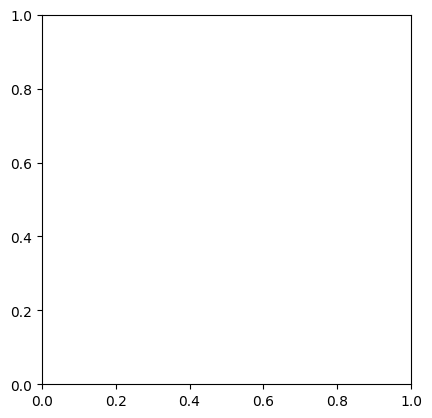

In [8]:
sample = '/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/VWF_043_MS211125_m3-homeostasis_movie_M1/VWF_043_MS211125_m3-homeostasis_movie_M1_Ch1_xyzCorrected.tif - T=2GFP.tiff'

sample_data = io.imread(sample)

sample_data

imshow(sample_data/sample_data.max())

In [125]:
mice = pd.read_csv('/Users/secchim/Documents/221103merged_metadata_and_mice.csv', low_memory=False)
print(mice)
submice= mice[['Age', 'Sex', 'Genotype','Treatment', 'BatchID','Datatype']]
submice=submice.drop_duplicates()
submice=submice[submice['Datatype']!='snap']
print(submice)
submice.to_csv('/Users/secchim/Documents/230136_merged_metadata_and_mice_submice.csv')

     Experiment mouse number  Mouse ID  \
0                         M1  104553-L   
1                         M1  104553-L   
2                         M1  104553-L   
3                         M1  104553-L   
4                         M1  104553-L   
...                      ...       ...   
1066                      M1  134779-R   
1067                      M1  134779-R   
1068                      M1  134779-R   
1069                      M1  134779-R   
1070                      M1  134779-R   

                                    Genotype      D.O.B.   Age Sex  \
0     Vwf Tg/+ Hoxb5Tg/+ IL1R het LeprCre WT  31/08/2021  11.1  M    
1     Vwf Tg/+ Hoxb5Tg/+ IL1R het LeprCre WT  31/08/2021  11.1  M    
2     Vwf Tg/+ Hoxb5Tg/+ IL1R het LeprCre WT  31/08/2021  11.1  M    
3     Vwf Tg/+ Hoxb5Tg/+ IL1R het LeprCre WT  31/08/2021  11.1  M    
4     Vwf Tg/+ Hoxb5Tg/+ IL1R het LeprCre WT  31/08/2021  11.1  M    
...                                      ...         ...   ...  ..   
1066 